# Comparison: Basic KAN vs Monotonic KAN

This notebook compares a basic Kolmogorov-Arnold Network (KAN) with a monotonic KAN where each spline has monotonic increasing/decreasing constraints. We'll implement both versions and compare their behavior on the same datasets.

## Key Differences:
- **Basic KAN**: Uses standard B-splines with no monotonicity constraints
- **Monotonic KAN**: Enforces monotonic behavior through coefficient ordering and direction parameters

## 1. Import Required Libraries and Setup

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from typing import List, Tuple
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Implement B-Spline Evaluation

We'll implement both basic B-splines and monotonic B-splines using the De Boor algorithm for evaluation. The De Boor algorithm is numerically stable and widely used in computer graphics and numerical analysis.

In [19]:
def de_boor_algorithm(t: float, knots: np.ndarray, control_points: np.ndarray, degree: int) -> float:
    """
    De Boor algorithm for B-spline evaluation.
    
    Args:
        t: Parameter value to evaluate
        knots: Knot vector
        control_points: Control points (coefficients)
        degree: Degree of the B-spline
    
    Returns:
        Evaluated B-spline value at parameter t
    """
    n = len(control_points)
    
    # Handle edge cases
    if t <= knots[0]:
        return control_points[0]
    if t >= knots[-1]:
        return control_points[-1]
    
    # Find the knot span
    k = degree
    for i in range(degree, len(knots) - degree):
        if knots[i] <= t < knots[i + 1]:
            k = i
            break
    
    # Ensure we have enough control points
    if k - degree < 0 or k >= len(control_points):
        k = min(max(k, degree), len(control_points) - 1)
    
    # Initialize with control points
    start_idx = max(0, k - degree)
    end_idx = min(len(control_points), k + 1)
    d = control_points[start_idx:end_idx].copy()
    
    if len(d) == 0:
        return 0.0
    
    # De Boor's algorithm
    for r in range(1, min(degree + 1, len(d))):
        for j in range(len(d) - 1, r - 1, -1):
            if j < len(d) and j - 1 >= 0:
                # Calculate alpha with bounds checking
                denom = knots[min(k + j - r + 1, len(knots) - 1)] - knots[max(k - degree + j, 0)]
                if abs(denom) > 1e-12:
                    alpha = (t - knots[max(k - degree + j, 0)]) / denom
                    alpha = max(0.0, min(1.0, alpha))  # Clamp alpha to [0,1]
                    d[j] = (1 - alpha) * d[j - 1] + alpha * d[j]
    
    return d[-1] if len(d) > 0 else 0.0

def evaluate_bspline_deboor(t_values: np.ndarray, knots: np.ndarray, 
                           control_points: np.ndarray, degree: int) -> np.ndarray:
    """
    Evaluate B-spline at multiple parameter values using De Boor algorithm.
    
    Args:
        t_values: Array of parameter values
        knots: Knot vector
        control_points: Control points (coefficients)
        degree: Degree of the B-spline
    
    Returns:
        Array of evaluated B-spline values
    """
    return np.array([de_boor_algorithm(t, knots, control_points, degree) for t in t_values])

print("De Boor algorithm implemented!")

De Boor algorithm implemented!


## 3. Create B-Spline Classes

We'll implement two types of B-splines:
1. **Basic B-Spline**: Standard B-spline with no constraints
2. **Monotonic B-Spline**: B-spline with monotonic constraints using cumulative sums

Testing Basic vs Monotonic B-Splines:
----------------------------------------
Basic B-spline - Control points: 11
Basic coefficients: [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004 -0.46341769]

Monotonic B-spline - Control points: 11
Raw coefficients: [0.36275373 0.74392783 0.56553707 0.34422299 0.94637087 0.15023453
 0.34551551 0.45627722 0.60893469 1.53793601 0.22273586]
Monotonic coefficients: [0.36275373 1.10668156 1.67221863 2.01644162 2.96281249 3.11304702
 3.45856253 3.91483975 4.52377444 6.06171045 6.28444631]
Direction parameter: 0.028
Is increasing: True


/net/store/cv/users/luniehaus/dev-uos/miniconda/envs/pykan/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8599 (\N{NORTH EAST ARROW}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


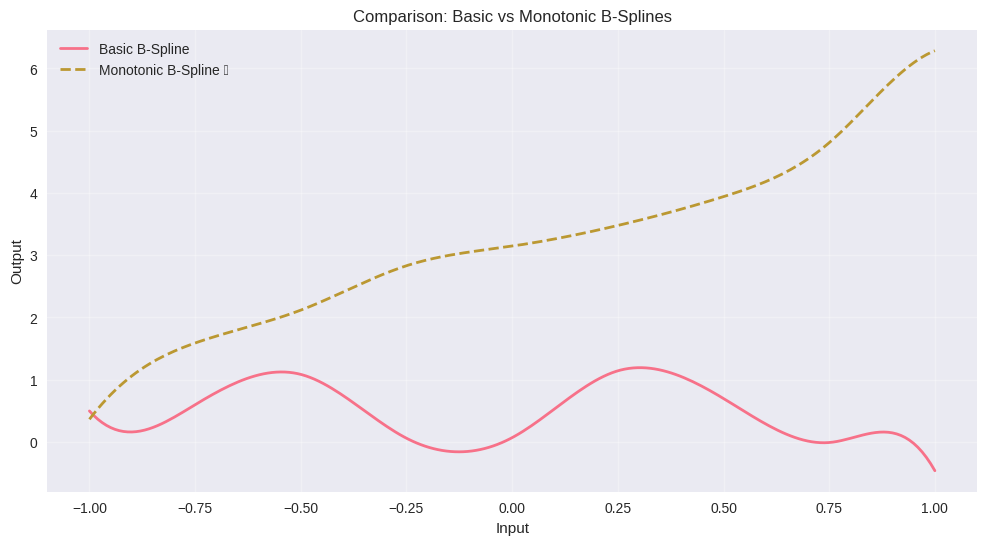

In [20]:
class BasicBSpline:
    """
    Basic B-spline implementation using De Boor algorithm.
    No monotonicity constraints - coefficients can be any values.
    """
    
    def __init__(self, grid_size: int = 8, degree: int = 3, domain: Tuple[float, float] = (-1.0, 1.0)):
        """
        Initialize basic B-spline.
        
        Args:
            grid_size: Number of grid intervals
            degree: Degree of the B-spline
            domain: Domain of the spline (min, max)
        """
        self.grid_size = grid_size
        self.degree = degree
        self.domain = domain
        
        # Create uniform knot vector with proper multiplicity at ends
        self.knots = self._create_knot_vector()
        
        # Number of control points
        self.n_control_points = len(self.knots) - degree - 1
        
        # Initialize coefficients randomly (can be positive or negative)
        self.coefficients = np.random.normal(0.0, 1.0, self.n_control_points)
        
    def _create_knot_vector(self) -> np.ndarray:
        """
        Create a uniform knot vector with proper end conditions.
        """
        # Internal knots
        internal_knots = np.linspace(self.domain[0], self.domain[1], self.grid_size + 1)
        
        # Add degree+1 knots at each end for proper boundary conditions
        start_knots = np.full(self.degree, self.domain[0])
        end_knots = np.full(self.degree, self.domain[1])
        
        return np.concatenate([start_knots, internal_knots, end_knots])
    
    def evaluate(self, t_values: np.ndarray) -> np.ndarray:
        """
        Evaluate the basic B-spline at given parameter values.
        
        Args:
            t_values: Parameter values to evaluate
        
        Returns:
            Evaluated spline values
        """
        # Clamp values to domain
        t_clamped = np.clip(t_values, self.domain[0], self.domain[1])
        
        return evaluate_bspline_deboor(t_clamped, self.knots, 
                                     self.coefficients, self.degree)
    
    def plot(self, ax=None, label: str = None, n_points: int = 200):
        """
        Plot the basic B-spline.
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        
        t_eval = np.linspace(self.domain[0], self.domain[1], n_points)
        y_eval = self.evaluate(t_eval)
        
        plot_label = label if label else "Basic B-Spline"
        
        ax.plot(t_eval, y_eval, linewidth=2, label=plot_label, linestyle='-')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Input')
        ax.set_ylabel('Output')
        
        if plot_label:
            ax.legend()
        
        return ax


class MonotonicBSpline:
    """
    Monotonic B-spline implementation using De Boor algorithm.
    Enforces monotonic behavior (increasing or decreasing) through cumulative sum of positive coefficients
    and a trainable direction parameter.
    """
    
    def __init__(self, grid_size: int = 8, degree: int = 3, domain: Tuple[float, float] = (-1.0, 1.0)):
        """
        Initialize monotonic B-spline.
        
        Args:
            grid_size: Number of grid intervals
            degree: Degree of the B-spline
            domain: Domain of the spline (min, max)
        """
        self.grid_size = grid_size
        self.degree = degree
        self.domain = domain
        
        # Create uniform knot vector with proper multiplicity at ends
        self.knots = self._create_knot_vector()
        
        # Number of control points
        self.n_control_points = len(self.knots) - degree - 1
        
        # Initialize positive coefficients (will be made monotonic via cumsum)
        self.raw_coefficients = np.random.exponential(1.0, self.n_control_points)
        
        # Trainable direction parameter: positive = increasing, negative = decreasing
        # Initialize randomly between -1 and 1
        self.direction_param = np.random.uniform(-1.0, 1.0)
        
    def _create_knot_vector(self) -> np.ndarray:
        """
        Create a uniform knot vector with proper end conditions.
        """
        # Internal knots
        internal_knots = np.linspace(self.domain[0], self.domain[1], self.grid_size + 1)
        
        # Add degree+1 knots at each end for proper boundary conditions
        start_knots = np.full(self.degree, self.domain[0])
        end_knots = np.full(self.degree, self.domain[1])
        
        return np.concatenate([start_knots, internal_knots, end_knots])
    
    @property
    def monotonic_coefficients(self) -> np.ndarray:
        """
        Get monotonic coefficients using cumulative sum with direction control.
        Positive direction_param gives increasing, negative gives decreasing.
        """
        # Ensure coefficients are positive and create monotonic sequence
        positive_coefs = np.abs(self.raw_coefficients)
        cumulative_coefs = np.cumsum(positive_coefs)
        
        # Apply direction: positive = increasing, negative = decreasing
        if self.direction_param >= 0:
            # Monotonic increasing
            return cumulative_coefs
        else:
            # Monotonic decreasing - reverse the cumulative order
            return cumulative_coefs[-1] - cumulative_coefs + cumulative_coefs[0]
    
    @property
    def is_increasing(self) -> bool:
        """Check if the spline is monotonically increasing."""
        return self.direction_param >= 0
    
    @property
    def is_decreasing(self) -> bool:
        """Check if the spline is monotonically decreasing."""
        return self.direction_param < 0
    
    def evaluate(self, t_values: np.ndarray) -> np.ndarray:
        """
        Evaluate the monotonic B-spline at given parameter values.
        
        Args:
            t_values: Parameter values to evaluate
        
        Returns:
            Evaluated spline values
        """
        # Clamp values to domain
        t_clamped = np.clip(t_values, self.domain[0], self.domain[1])
        
        return evaluate_bspline_deboor(t_clamped, self.knots, 
                                     self.monotonic_coefficients, self.degree)
    
    def plot(self, ax=None, label: str = None, n_points: int = 200):
        """
        Plot the monotonic B-spline.
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        
        t_eval = np.linspace(self.domain[0], self.domain[1], n_points)
        y_eval = self.evaluate(t_eval)
        
        # Create label with direction information
        direction_str = "↗" if self.is_increasing else "↘"
        if label:
            plot_label = f"{label} {direction_str}"
        else:
            plot_label = f"Monotonic Spline {direction_str}"
        
        ax.plot(t_eval, y_eval, linewidth=2, label=plot_label, linestyle='--')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Input')
        ax.set_ylabel('Output')
        
        if plot_label:
            ax.legend()
        
        return ax


# Test both types of splines
print("Testing Basic vs Monotonic B-Splines:")
print("-" * 40)

# Create both types of splines
basic_spline = BasicBSpline(grid_size=8, degree=3)
monotonic_spline = MonotonicBSpline(grid_size=8, degree=3)

print(f"Basic B-spline - Control points: {basic_spline.n_control_points}")
print(f"Basic coefficients: {basic_spline.coefficients}")
print()
print(f"Monotonic B-spline - Control points: {monotonic_spline.n_control_points}")
print(f"Raw coefficients: {monotonic_spline.raw_coefficients}")
print(f"Monotonic coefficients: {monotonic_spline.monotonic_coefficients}")
print(f"Direction parameter: {monotonic_spline.direction_param:.3f}")
print(f"Is increasing: {monotonic_spline.is_increasing}")

# Compare both splines visually
fig, ax = plt.subplots(figsize=(12, 6))
basic_spline.plot(ax=ax, label="Basic B-Spline")
monotonic_spline.plot(ax=ax, label="Monotonic B-Spline")
ax.set_title("Comparison: Basic vs Monotonic B-Splines")
plt.show()

## 4. Build KAN Architectures: Basic vs Monotonic

Now we'll implement both KAN architectures and compare their structures and behaviors.

In [21]:
class BasicKANLayer:
    """
    A single layer in the basic Kolmogorov-Arnold Network using standard B-splines.
    """
    def __init__(self, input_dim: int, output_dim: int, grid_size: int = 8, degree: int = 3):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.grid_size = grid_size
        self.degree = degree
        
        # Create a spline for each input-output connection
        self.splines = []
        for i in range(input_dim):
            row = []
            for j in range(output_dim):
                spline = BasicBSpline(grid_size=grid_size, degree=degree)
                row.append(spline)
            self.splines.append(row)
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Forward pass through the layer.
        
        Args:
            x: Input array of shape (batch_size, input_dim)
        
        Returns:
            Output array of shape (batch_size, output_dim)
        """
        batch_size = x.shape[0]
        output = np.zeros((batch_size, self.output_dim))
        
        for j in range(self.output_dim):
            for i in range(self.input_dim):
                # Evaluate spline for input i to output j
                spline_output = self.splines[i][j].evaluate(x[:, i])
                output[:, j] += spline_output
        
        return output
    
    def get_spline(self, input_idx: int, output_idx: int) -> BasicBSpline:
        """Get the spline connecting input_idx to output_idx."""
        return self.splines[input_idx][output_idx]


class MonotonicKANLayer:
    """
    A single layer in the Kolmogorov-Arnold Network using monotonic B-splines.
    """
    def __init__(self, input_dim: int, output_dim: int, grid_size: int = 8, degree: int = 3):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.grid_size = grid_size
        self.degree = degree
        
        # Create a spline for each input-output connection
        self.splines = []
        for i in range(input_dim):
            row = []
            for j in range(output_dim):
                spline = MonotonicBSpline(grid_size=grid_size, degree=degree)
                row.append(spline)
            self.splines.append(row)
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Forward pass through the layer.
        
        Args:
            x: Input array of shape (batch_size, input_dim)
        
        Returns:
            Output array of shape (batch_size, output_dim)
        """
        batch_size = x.shape[0]
        output = np.zeros((batch_size, self.output_dim))
        
        for j in range(self.output_dim):
            for i in range(self.input_dim):
                # Evaluate spline for input i to output j
                spline_output = self.splines[i][j].evaluate(x[:, i])
                output[:, j] += spline_output
        
        return output
    
    def get_spline(self, input_idx: int, output_idx: int) -> MonotonicBSpline:
        """Get the spline connecting input_idx to output_idx."""
        return self.splines[input_idx][output_idx]

print("KAN Layer classes implemented successfully!")
print("- BasicKANLayer: Uses standard B-splines")
print("- MonotonicKANLayer: Uses monotonic B-splines")

KAN Layer classes implemented successfully!
- BasicKANLayer: Uses standard B-splines
- MonotonicKANLayer: Uses monotonic B-splines


In [22]:
class BasicKAN:
    """
    Basic Kolmogorov-Arnold Network with standard B-splines.
    """
    def __init__(self, layer_dims: List[int], grid_size: int = 8, degree: int = 3, 
                 domain: Tuple[float, float] = (-1, 1)):
        self.layer_dims = layer_dims
        self.layer_sizes = layer_dims
        self.grid_size = grid_size
        self.degree = degree
        self.domain = domain
        self.depth = len(layer_dims) - 1
        
        # Create layers
        self.layers = []
        for i in range(self.depth):
            layer = BasicKANLayer(
                input_dim=layer_dims[i],
                output_dim=layer_dims[i+1],
                grid_size=grid_size,
                degree=degree
            )
            self.layers.append(layer)
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Forward pass through the entire network.
        
        Args:
            x: Input array of shape (batch_size, input_dim)
        
        Returns:
            Output array of shape (batch_size, output_dim)
        """
        current = x.copy()
        
        for layer in self.layers:
            current = layer.forward(current)
        
        return current
    
    def predict_proba(self, x: np.ndarray) -> np.ndarray:
        """
        Predict class probabilities using softmax activation.
        """
        logits = self.forward(x)
        
        # Apply softmax
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        probabilities = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        
        return probabilities
    
    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Make class predictions.
        """
        probabilities = self.predict_proba(x)
        return np.argmax(probabilities, axis=1)
    
    def get_all_splines(self) -> List[Tuple[int, int, int, BasicBSpline]]:
        """
        Get all splines in the network with their coordinates.
        
        Returns:
            List of tuples (layer_idx, input_idx, output_idx, spline)
        """
        all_splines = []
        
        for layer_idx, layer in enumerate(self.layers):
            for i in range(layer.input_dim):
                for j in range(layer.output_dim):
                    spline = layer.get_spline(i, j)
                    all_splines.append((layer_idx, i, j, spline))
        
        return all_splines


class MonotonicKAN:
    """
    Kolmogorov-Arnold Network with monotonic B-splines.
    """
    def __init__(self, layer_dims: List[int], grid_size: int = 8, degree: int = 3, 
                 domain: Tuple[float, float] = (-1, 1)):
        self.layer_dims = layer_dims
        self.layer_sizes = layer_dims
        self.grid_size = grid_size
        self.degree = degree
        self.domain = domain
        self.depth = len(layer_dims) - 1
        
        # Create layers
        self.layers = []
        for i in range(self.depth):
            layer = MonotonicKANLayer(
                input_dim=layer_dims[i],
                output_dim=layer_dims[i+1],
                grid_size=grid_size,
                degree=degree
            )
            self.layers.append(layer)
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Forward pass through the entire network.
        """
        current = x.copy()
        
        for layer in self.layers:
            current = layer.forward(current)
        
        return current
    
    def predict_proba(self, x: np.ndarray) -> np.ndarray:
        """
        Predict class probabilities using softmax activation.
        """
        logits = self.forward(x)
        
        # Apply softmax
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        probabilities = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        
        return probabilities
    
    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Make class predictions.
        """
        probabilities = self.predict_proba(x)
        return np.argmax(probabilities, axis=1)
    
    def get_all_splines(self) -> List[Tuple[int, int, int, MonotonicBSpline]]:
        """
        Get all splines in the network with their coordinates.
        """
        all_splines = []
        
        for layer_idx, layer in enumerate(self.layers):
            for i in range(layer.input_dim):
                for j in range(layer.output_dim):
                    spline = layer.get_spline(i, j)
                    all_splines.append((layer_idx, i, j, spline))
        
        return all_splines

print("KAN Network classes implemented successfully!")
print("- BasicKAN: Standard KAN with unrestricted B-splines")
print("- MonotonicKAN: KAN with monotonic B-splines")

KAN Network classes implemented successfully!
- BasicKAN: Standard KAN with unrestricted B-splines
- MonotonicKAN: KAN with monotonic B-splines


## 5. Create Visualization Functions

Functions to visualize and compare splines from both types of KANs.

In [23]:
def plot_all_splines_comparison(basic_kan, monotonic_kan, n_points: int = 200, figsize: Tuple[int, int] = (18, 12)):
    """
    Plot splines from both Basic and Monotonic KANs side by side for comparison.
    
    Args:
        basic_kan: The BasicKAN instance
        monotonic_kan: The MonotonicKAN instance
        n_points: Number of points for evaluation
        figsize: Figure size
    """
    basic_splines = basic_kan.get_all_splines()
    monotonic_splines = monotonic_kan.get_all_splines()
    
    assert len(basic_splines) == len(monotonic_splines), "Networks must have same architecture"
    
    n_splines = len(basic_splines)
    
    # Calculate subplot layout
    n_cols = min(4, n_splines)
    n_rows = (n_splines + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Evaluation points
    t_eval = np.linspace(basic_kan.domain[0], basic_kan.domain[1], n_points)
    
    # Plot each spline pair
    for idx in range(n_splines):
        ax = axes[idx]
        
        # Get splines
        basic_layer_idx, basic_i, basic_j, basic_spline = basic_splines[idx]
        mono_layer_idx, mono_i, mono_j, mono_spline = monotonic_splines[idx]
        
        # Evaluate splines
        basic_y = basic_spline.evaluate(t_eval)
        mono_y = mono_spline.evaluate(t_eval)
        
        # Plot both splines
        ax.plot(t_eval, basic_y, linewidth=2, color='blue', label='Basic KAN', alpha=0.8)
        ax.plot(t_eval, mono_y, linewidth=2, color='red', linestyle='--', label='Monotonic KAN', alpha=0.8)
        
        # Customize the plot
        ax.set_title(f'Layer {basic_layer_idx}, Input {basic_i} → Output {basic_j}', fontsize=10)
        ax.set_xlabel('Input')
        ax.set_ylabel('Output')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        
        # Add monotonicity verification for monotonic spline
        mono_diff = np.diff(mono_y)
        if hasattr(mono_spline, 'direction_param'):
            if mono_spline.direction_param >= 0:
                is_monotonic = np.all(mono_diff >= -1e-10)
                expected_direction = "increasing"
            else:
                is_monotonic = np.all(mono_diff <= 1e-10)
                expected_direction = "decreasing"
        else:
            # Determine monotonicity empirically
            is_increasing = np.all(mono_diff >= -1e-10)
            is_decreasing = np.all(mono_diff <= 1e-10)
            is_monotonic = is_increasing or is_decreasing
            expected_direction = "increasing" if is_increasing else "decreasing" if is_decreasing else "non-monotonic"
        
        # Add monotonicity text
        mono_symbol = "✓" if is_monotonic else "✗"
        ax.text(0.05, 0.05, f'{mono_symbol} Mono: {expected_direction}', 
                transform=ax.transAxes, fontsize=7,
                bbox=dict(boxstyle='round', facecolor='lightgreen' if is_monotonic else 'lightcoral', alpha=0.7))
    
    # Hide unused subplots
    for idx in range(n_splines, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle(f'Spline Comparison: Basic vs Monotonic KAN (Architecture: {basic_kan.layer_dims})', 
                 fontsize=14, y=1.02)
    plt.show()


def plot_network_responses_comparison(basic_kan, monotonic_kan, n_points: int = 50, figsize: Tuple[int, int] = (15, 10)):
    """
    Compare the overall network responses for 2D input.
    """
    if basic_kan.layer_dims[0] != 2:
        print("Network response plotting only supports 2D input.")
        return
    
    # Create a grid of input points
    x1 = np.linspace(basic_kan.domain[0], basic_kan.domain[1], n_points)
    x2 = np.linspace(basic_kan.domain[0], basic_kan.domain[1], n_points)
    X1, X2 = np.meshgrid(x1, x2)
    
    # Flatten for network evaluation
    input_points = np.column_stack([X1.flatten(), X2.flatten()])
    
    # Evaluate both networks
    basic_output = basic_kan.forward(input_points)
    mono_output = monotonic_kan.forward(input_points)
    output_dim = basic_output.shape[1]
    
    # Plot each output dimension for both networks
    fig, axes = plt.subplots(2, output_dim, figsize=figsize)
    if output_dim == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(output_dim):
        # Basic KAN
        Z_basic = basic_output[:, i].reshape(X1.shape)
        im1 = axes[0, i].contourf(X1, X2, Z_basic, levels=20, cmap='viridis')
        axes[0, i].set_title(f'Basic KAN - Output {i}')
        axes[0, i].set_xlabel('Input 1')
        axes[0, i].set_ylabel('Input 2')
        plt.colorbar(im1, ax=axes[0, i])
        
        # Monotonic KAN
        Z_mono = mono_output[:, i].reshape(X1.shape)
        im2 = axes[1, i].contourf(X1, X2, Z_mono, levels=20, cmap='plasma')
        axes[1, i].set_title(f'Monotonic KAN - Output {i}')
        axes[1, i].set_xlabel('Input 1')
        axes[1, i].set_ylabel('Input 2')
        plt.colorbar(im2, ax=axes[1, i])
    
    plt.tight_layout()
    plt.suptitle(f'Network Response Comparison (Architecture: {basic_kan.layer_dims})', fontsize=14, y=1.02)
    plt.show()


def analyze_spline_properties(kan, kan_type: str = "KAN"):
    """
    Analyze and report properties of splines in a KAN.
    """
    all_splines = kan.get_all_splines()
    
    print(f"\n{kan_type} Spline Analysis:")
    print("-" * 40)
    print(f"Total splines: {len(all_splines)}")
    
    # Sample spline for evaluation
    t_eval = np.linspace(kan.domain[0], kan.domain[1], 100)
    
    monotonic_increasing = 0
    monotonic_decreasing = 0
    non_monotonic = 0
    
    for layer_idx, input_idx, output_idx, spline in all_splines:
        y_eval = spline.evaluate(t_eval)
        diff = np.diff(y_eval)
        
        is_increasing = np.all(diff >= -1e-10)
        is_decreasing = np.all(diff <= 1e-10)
        
        if is_increasing:
            monotonic_increasing += 1
        elif is_decreasing:
            monotonic_decreasing += 1
        else:
            non_monotonic += 1
    
    print(f"Monotonic increasing: {monotonic_increasing}")
    print(f"Monotonic decreasing: {monotonic_decreasing}")
    print(f"Non-monotonic: {non_monotonic}")
    print(f"Monotonic ratio: {(monotonic_increasing + monotonic_decreasing) / len(all_splines):.2%}")

print("Comparison plotting functions created successfully!")

Comparison plotting functions created successfully!


In [24]:
# Create both types of KANs with identical architectures for comparison
print("Creating both Basic and Monotonic KANs for comparison...")
print("=" * 60)

architecture = [2, 3, 2]  # Simple architecture for clear comparison
grid_size = 8
degree = 3
domain = (-2.0, 2.0)

# Create both networks
basic_kan = BasicKAN(
    layer_dims=architecture,
    grid_size=grid_size,
    degree=degree,
    domain=domain
)

monotonic_kan = MonotonicKAN(
    layer_dims=architecture,
    grid_size=grid_size,
    degree=degree,
    domain=domain
)

print(f"Architecture: {architecture}")
print(f"Grid size: {grid_size}")
print(f"Degree: {degree}")
print(f"Domain: {domain}")
print()

print("Basic KAN:")
print(f"  Total splines: {len(basic_kan.get_all_splines())}")
analyze_spline_properties(basic_kan, "Basic")

print()

print("Monotonic KAN:")
print(f"  Total splines: {len(monotonic_kan.get_all_splines())}")
analyze_spline_properties(monotonic_kan, "Monotonic")

# Test with same input data
test_input = np.array([
    [-1.5, 0.5],
    [0.0, 1.0],
    [1.2, -0.8],
    [0.5, 0.5]
])

print(f"\nTesting both networks with sample data:")
print(f"Input shape: {test_input.shape}")

basic_output = basic_kan.forward(test_input)
mono_output = monotonic_kan.forward(test_input)

print(f"Basic KAN output shape: {basic_output.shape}")
print(f"Monotonic KAN output shape: {mono_output.shape}")
print()
print("Sample outputs:")
print("Basic KAN:")
print(basic_output)
print("Monotonic KAN:")
print(mono_output)

Creating both Basic and Monotonic KANs for comparison...
Architecture: [2, 3, 2]
Grid size: 8
Degree: 3
Domain: (-2.0, 2.0)

Basic KAN:
  Total splines: 12

Basic Spline Analysis:
----------------------------------------
Total splines: 12
Monotonic increasing: 0
Monotonic decreasing: 0
Non-monotonic: 12
Monotonic ratio: 0.00%

Monotonic KAN:
  Total splines: 12

Monotonic Spline Analysis:
----------------------------------------
Total splines: 12
Monotonic increasing: 9
Monotonic decreasing: 3
Non-monotonic: 0
Monotonic ratio: 100.00%

Testing both networks with sample data:
Input shape: (4, 2)
Basic KAN output shape: (4, 2)
Monotonic KAN output shape: (4, 2)

Sample outputs:
Basic KAN:
[[ 1.44814885  0.29456272]
 [ 0.22158024 -1.97773709]
 [ 0.53910002  0.81004824]
 [ 1.01027478 -0.73044171]]
Monotonic KAN:
[[16.56820897 24.04319344]
 [16.56820897 24.04319344]
 [16.56820897 24.04319344]
 [16.56820897 24.04319344]]


Comparing splines from Basic vs Monotonic KANs...


/tmp/ipykernel_1831275/67700375.py:82: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()


/net/store/cv/users/luniehaus/dev-uos/miniconda/envs/pykan/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


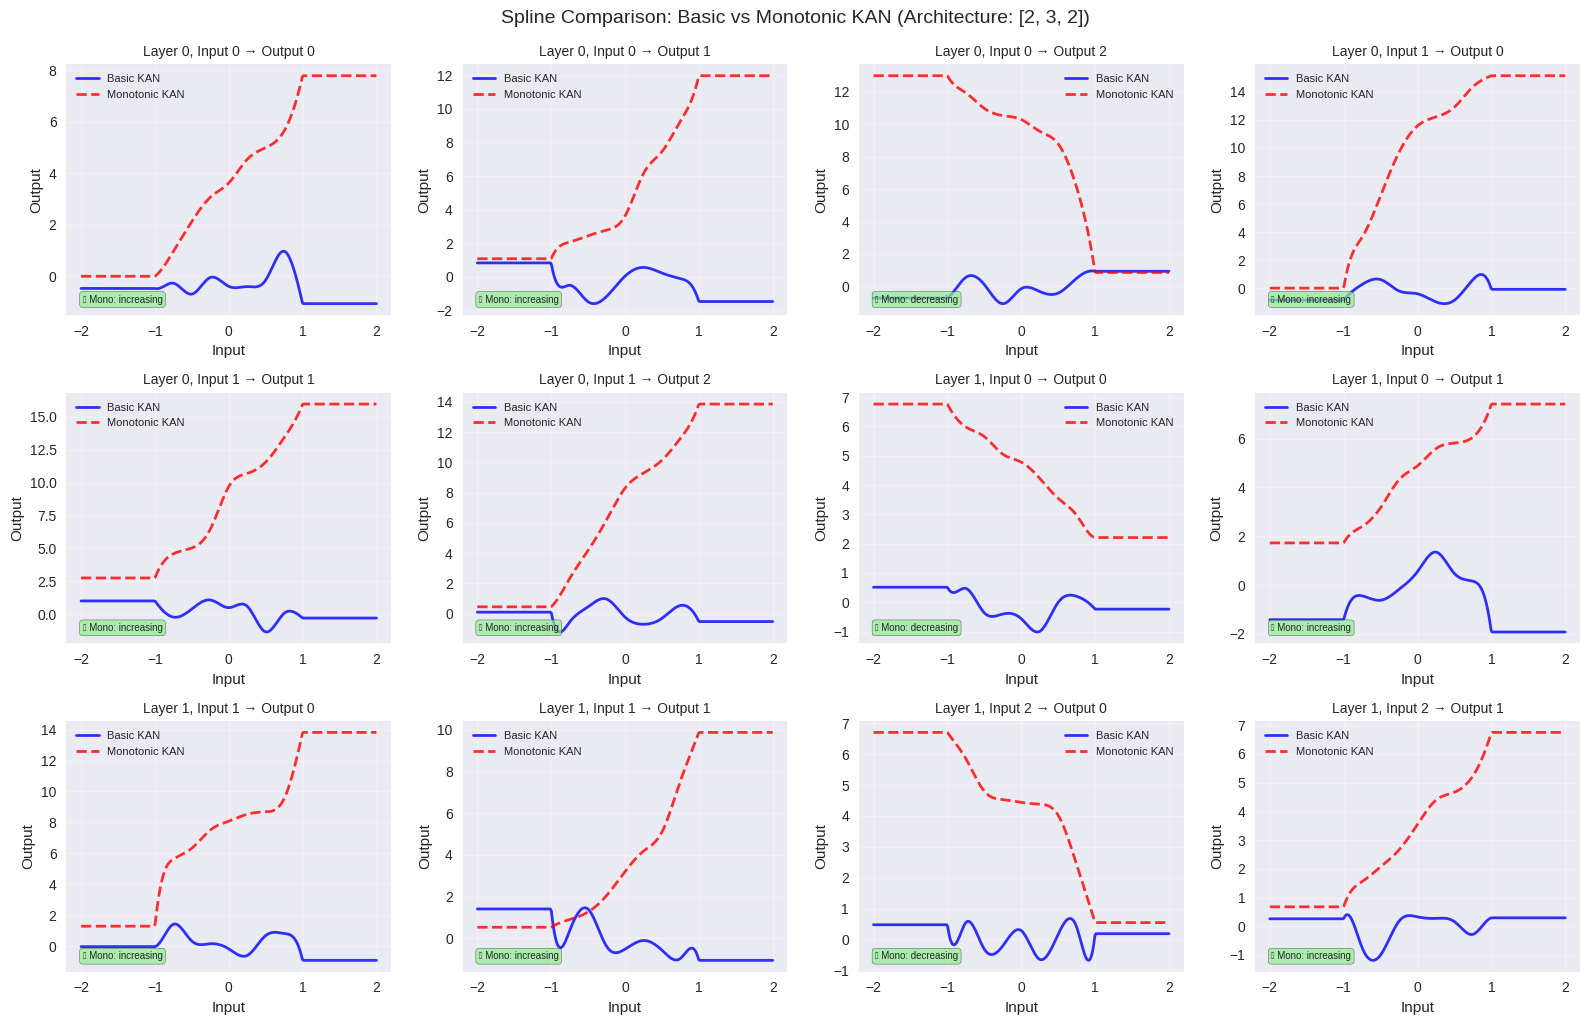

In [25]:
# Visualize spline comparison between Basic and Monotonic KANs
print("Comparing splines from Basic vs Monotonic KANs...")
plot_all_splines_comparison(basic_kan, monotonic_kan, n_points=300, figsize=(16, 10))

## 6. Dataset Creation and Training Comparison

Let's create a classification dataset and train both KAN types to compare their performance.

Comparing network responses...


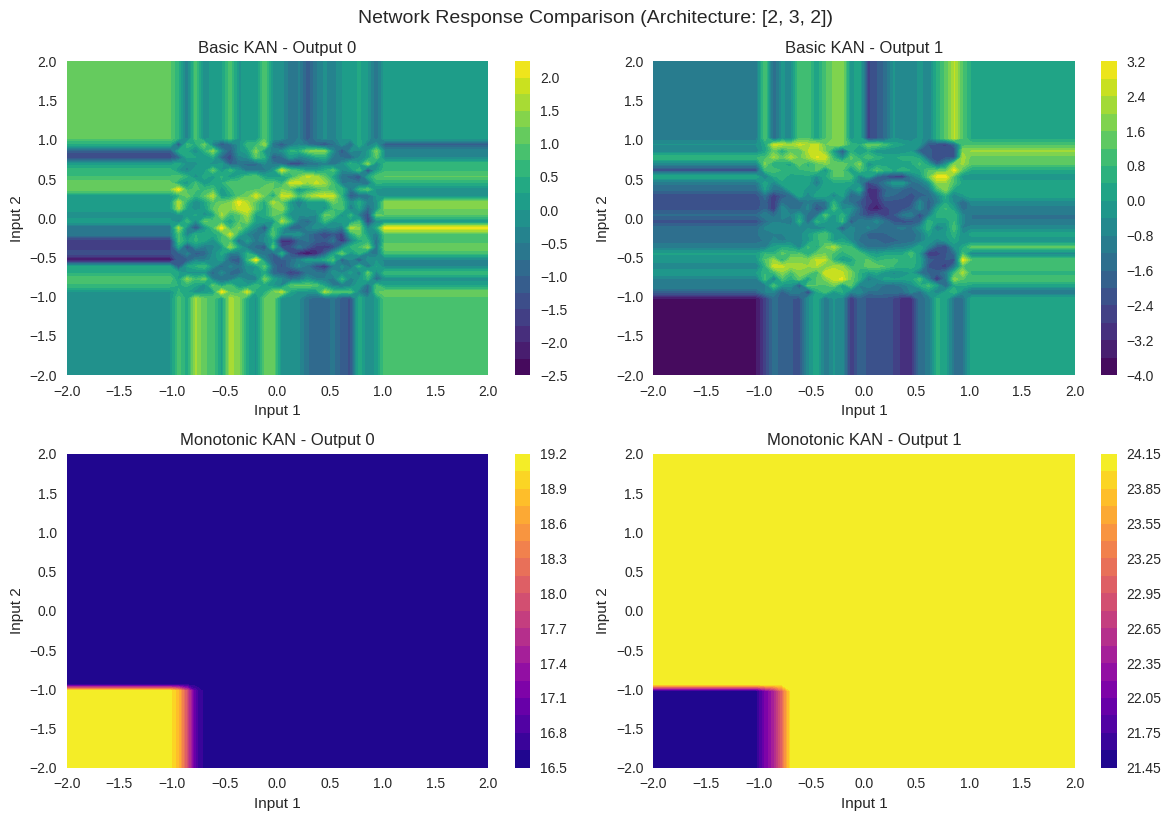

In [26]:
# Compare network responses on a 2D grid
print("Comparing network responses...")
plot_network_responses_comparison(basic_kan, monotonic_kan, n_points=50, figsize=(12, 8))

## 7. Training Functions and Dataset Creation

In [27]:
# Configuration for classification task
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

# Classification dataset parameters
n_classes = 2**2  # 4 classes
m = 15  # points per class
n_epochs = 80
hidden = [4, 3]
architecture = [2] + hidden + [n_classes]

print(f"Classification architecture: {architecture}")

args_dict = {
    'seed': 2024,
    'kan_architecture': architecture,
    'grid': 8,
    'k': 3,
    'bounds': (-2, 2),
    'learning_rate': 1e-3,
    'n_classes': n_classes,
    'm': m,
    'n_epochs': n_epochs
}
args = Args(**args_dict)

def create_evenly_spread_dataset(n_classes=4, m=10, bounds=(-2, 2), seed=42):
    """
    Create an evenly spread classification dataset.
    """
    np.random.seed(seed)
    # Compute grid size (try to make it as square as possible)
    grid_size = int(np.ceil(np.sqrt(n_classes)))
    x_edges = np.linspace(bounds[0], bounds[1], grid_size + 1)
    y_edges = np.linspace(bounds[0], bounds[1], grid_size + 1)
    data = []
    labels = []
    class_idx = 0
    
    for i in range(grid_size):
        for j in range(grid_size):
            if class_idx >= n_classes:
                break
            x_min, x_max = x_edges[i], x_edges[i+1]
            y_min, y_max = y_edges[j], y_edges[j+1]
            # Sample m points uniformly within this cell
            xs = np.random.uniform(x_min, x_max, size=(m, 1))
            ys = np.random.uniform(y_min, y_max, size=(m, 1))
            points = np.hstack([xs, ys])
            data.append(points)
            labels.extend([class_idx] * m)
            class_idx += 1
        if class_idx >= n_classes:
            break
    
    data = np.vstack(data)
    labels = np.array(labels)
    return data, labels

def softmax(x):
    """Softmax activation function for classification."""
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    """Cross-entropy loss for classification."""
    n_samples, n_classes = y_pred.shape
    y_one_hot = np.zeros((n_samples, n_classes))
    y_one_hot[np.arange(n_samples), y_true] = 1
    
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    
    return -np.mean(np.sum(y_one_hot * np.log(y_pred), axis=1))

def classification_accuracy(y_pred, y_true):
    """Calculate classification accuracy."""
    predicted_classes = np.argmax(y_pred, axis=1)
    return np.mean(predicted_classes == y_true)

def simple_training_step(kan, X: np.ndarray, y: np.ndarray, 
                        learning_rate: float = 0.01, 
                        direction_lr: float = 0.001) -> Tuple[float, float]:
    """
    Perform a simple training step for classification.
    Works with both BasicKAN and MonotonicKAN.
    """
    # Forward pass
    logits = kan.forward(X)
    
    # Apply softmax to get probabilities
    y_pred = softmax(logits)
    
    # Calculate loss and accuracy
    loss = cross_entropy_loss(y_pred, y)
    accuracy = classification_accuracy(y_pred, y)
    
    # Simple gradient-like update
    gradient_magnitude = loss
    
    for layer in kan.layers:
        for i in range(layer.input_dim):
            for j in range(layer.output_dim):
                spline = layer.splines[i][j]
                
                if hasattr(spline, 'raw_coefficients'):
                    # Monotonic spline
                    adjustment = learning_rate * gradient_magnitude * np.random.normal(0, 0.1, len(spline.raw_coefficients))
                    spline.raw_coefficients = np.abs(spline.raw_coefficients + adjustment)
                    
                    # Update direction parameter
                    direction_adjustment = direction_lr * gradient_magnitude * np.random.normal(0, 0.5)
                    spline.direction_param += direction_adjustment
                    spline.direction_param = np.clip(spline.direction_param, -2.0, 2.0)
                else:
                    # Basic spline
                    adjustment = learning_rate * gradient_magnitude * np.random.normal(0, 0.1, len(spline.coefficients))
                    spline.coefficients += adjustment
    
    return loss, accuracy

def train_kan(kan, X: np.ndarray, y: np.ndarray, 
              epochs: int = 100, learning_rate: float = 0.01,
              direction_lr: float = 0.001,
              verbose: bool = True) -> Tuple[List[float], List[float]]:
    """
    Train a KAN (Basic or Monotonic) for classification.
    """
    losses = []
    accuracies = []
    
    kan_type = "Monotonic" if hasattr(kan.layers[0].splines[0][0], 'raw_coefficients') else "Basic"
    
    for epoch in range(epochs):
        loss, accuracy = simple_training_step(kan, X, y, learning_rate, direction_lr)
        losses.append(loss)
        accuracies.append(accuracy)
        
        if verbose and (epoch + 1) % 20 == 0:
            print(f"{kan_type} KAN - Epoch {epoch + 1}/{epochs}, Loss: {loss:.6f}, Accuracy: {accuracy:.4f}")
    
    return losses, accuracies

print("Training functions created for both KAN types!")

Classification architecture: [2, 4, 3, 4]
Training functions created for both KAN types!


Classification dataset created:
  Input shape: (60, 2)
  Labels shape: (60,)
  Number of classes: 4
  Points per class: 15
\nTrain set: 48 samples
Test set: 12 samples


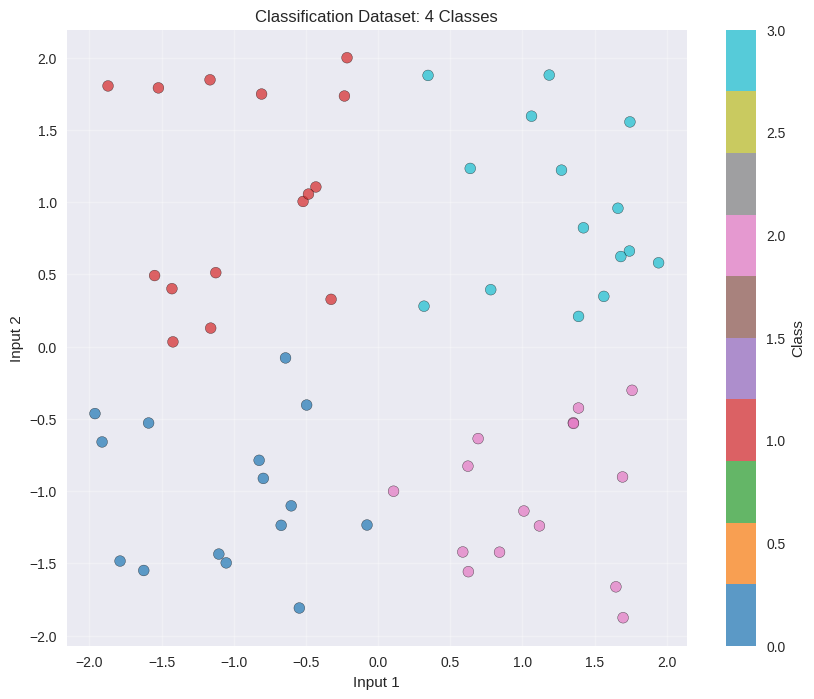

\nCreating both Basic and Monotonic KANs for classification...
Architecture: [2, 4, 3, 4]
Basic KAN splines: 32
Monotonic KAN splines: 32
\nInitial Performance:
Basic KAN - Loss: 1.900062, Accuracy: 0.3333
Monotonic KAN - Loss: 13.042294, Accuracy: 0.2500
\nReady for training comparison!


In [28]:
# Create classification dataset
X_train, y_train = create_evenly_spread_dataset(
    n_classes=args.n_classes,
    m=args.m,
    bounds=args.bounds,
    seed=args.seed
)

print(f"Classification dataset created:")
print(f"  Input shape: {X_train.shape}")
print(f"  Labels shape: {y_train.shape}")
print(f"  Number of classes: {args.n_classes}")
print(f"  Points per class: {args.m}")

# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\\nTrain set: {X_train_split.shape[0]} samples")
print(f"Test set: {X_test_split.shape[0]} samples")

# Visualize the dataset
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
                    cmap='tab10', edgecolor='k', s=60, alpha=0.7)
ax.set_xlabel('Input 1')
ax.set_ylabel('Input 2')
ax.set_title(f'Classification Dataset: {args.n_classes} Classes')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Class')
plt.show()

# Create both KANs for classification comparison
print("\\nCreating both Basic and Monotonic KANs for classification...")

basic_classification_kan = BasicKAN(
    layer_dims=args.kan_architecture,
    grid_size=args.grid,
    degree=args.k,
    domain=args.bounds
)

monotonic_classification_kan = MonotonicKAN(
    layer_dims=args.kan_architecture,
    grid_size=args.grid,
    degree=args.k,
    domain=args.bounds
)

print(f"Architecture: {args.kan_architecture}")
print(f"Basic KAN splines: {len(basic_classification_kan.get_all_splines())}")
print(f"Monotonic KAN splines: {len(monotonic_classification_kan.get_all_splines())}")

# Get initial performance for both networks
basic_initial = basic_classification_kan.forward(X_train_split)
basic_initial_probs = softmax(basic_initial)
basic_initial_loss = cross_entropy_loss(basic_initial_probs, y_train_split)
basic_initial_acc = classification_accuracy(basic_initial_probs, y_train_split)

mono_initial = monotonic_classification_kan.forward(X_train_split)
mono_initial_probs = softmax(mono_initial)
mono_initial_loss = cross_entropy_loss(mono_initial_probs, y_train_split)
mono_initial_acc = classification_accuracy(mono_initial_probs, y_train_split)

print(f"\\nInitial Performance:")
print(f"Basic KAN - Loss: {basic_initial_loss:.6f}, Accuracy: {basic_initial_acc:.4f}")
print(f"Monotonic KAN - Loss: {mono_initial_loss:.6f}, Accuracy: {mono_initial_acc:.4f}")

print("\\nReady for training comparison!")

In [29]:
# Train both KANs and compare their performance
print("Training both Basic and Monotonic KANs...")
print("=" * 60)

# Train Basic KAN
print("Training Basic KAN:")
basic_losses, basic_accuracies = train_kan(
    kan=basic_classification_kan,
    X=X_train_split,
    y=y_train_split,
    epochs=args.n_epochs,
    learning_rate=args.learning_rate,
    verbose=True
)

print("\\n" + "=" * 60)
print("Training Monotonic KAN:")
mono_losses, mono_accuracies = train_kan(
    kan=monotonic_classification_kan,
    X=X_train_split,
    y=y_train_split,
    epochs=args.n_epochs,
    learning_rate=args.learning_rate,
    direction_lr=0.005,
    verbose=True
)

# Get final performance on training set
basic_final = basic_classification_kan.forward(X_train_split)
basic_final_probs = softmax(basic_final)
basic_final_loss = cross_entropy_loss(basic_final_probs, y_train_split)
basic_final_acc = classification_accuracy(basic_final_probs, y_train_split)

mono_final = monotonic_classification_kan.forward(X_train_split)
mono_final_probs = softmax(mono_final)
mono_final_loss = cross_entropy_loss(mono_final_probs, y_train_split)
mono_final_acc = classification_accuracy(mono_final_probs, y_train_split)

# Test on held-out data
basic_test = basic_classification_kan.forward(X_test_split)
basic_test_probs = softmax(basic_test)
basic_test_loss = cross_entropy_loss(basic_test_probs, y_test_split)
basic_test_acc = classification_accuracy(basic_test_probs, y_test_split)

mono_test = monotonic_classification_kan.forward(X_test_split)
mono_test_probs = softmax(mono_test)
mono_test_loss = cross_entropy_loss(mono_test_probs, y_test_split)
mono_test_acc = classification_accuracy(mono_test_probs, y_test_split)

print("\\n" + "=" * 60)
print("TRAINING COMPARISON RESULTS")
print("=" * 60)
print("Final Training Performance:")
print(f"Basic KAN     - Loss: {basic_final_loss:.6f}, Accuracy: {basic_final_acc:.4f}")
print(f"Monotonic KAN - Loss: {mono_final_loss:.6f}, Accuracy: {mono_final_acc:.4f}")
print()
print("Test Performance:")
print(f"Basic KAN     - Loss: {basic_test_loss:.6f}, Accuracy: {basic_test_acc:.4f}")
print(f"Monotonic KAN - Loss: {mono_test_loss:.6f}, Accuracy: {mono_test_acc:.4f}")
print()
print("Training Improvement:")
print(f"Basic KAN     - Loss: {((basic_initial_loss - basic_final_loss) / basic_initial_loss * 100):.1f}%, Acc: +{((basic_final_acc - basic_initial_acc) * 100):.1f}%")
print(f"Monotonic KAN - Loss: {((mono_initial_loss - mono_final_loss) / mono_initial_loss * 100):.1f}%, Acc: +{((mono_final_acc - mono_initial_acc) * 100):.1f}%")

Training both Basic and Monotonic KANs...
Training Basic KAN:
Basic KAN - Epoch 20/80, Loss: 1.896366, Accuracy: 0.3125
Basic KAN - Epoch 20/80, Loss: 1.896366, Accuracy: 0.3125


Basic KAN - Epoch 40/80, Loss: 1.896174, Accuracy: 0.3333
Basic KAN - Epoch 60/80, Loss: 1.885878, Accuracy: 0.3125
Basic KAN - Epoch 60/80, Loss: 1.885878, Accuracy: 0.3125
Basic KAN - Epoch 80/80, Loss: 1.890075, Accuracy: 0.3333
\n============================================================
Training Monotonic KAN:
Monotonic KAN - Epoch 20/80, Loss: 13.022315, Accuracy: 0.2500
Monotonic KAN - Epoch 40/80, Loss: 16.626689, Accuracy: 0.2500
Monotonic KAN - Epoch 60/80, Loss: 16.659211, Accuracy: 0.2500
Basic KAN - Epoch 80/80, Loss: 1.890075, Accuracy: 0.3333
\n============================================================
Training Monotonic KAN:
Monotonic KAN - Epoch 20/80, Loss: 13.022315, Accuracy: 0.2500
Monotonic KAN - Epoch 40/80, Loss: 16.626689, Accuracy: 0.2500
Monotonic KAN - Epoch 60/80, Loss: 16.659211, Accuracy: 0.2500
Monotonic KAN - Epoch 80/80, Loss: 16.646157, Accuracy: 0.2500
\n============================================================
TRAINING COMPARISON RESULTS
Fina


Basic Spline Analysis:
----------------------------------------
Total splines: 32
Monotonic increasing: 0
Monotonic decreasing: 0
Non-monotonic: 32
Monotonic ratio: 0.00%

Monotonic Spline Analysis:
----------------------------------------
Total splines: 32
Monotonic increasing: 20
Monotonic decreasing: 12
Non-monotonic: 0
Monotonic ratio: 100.00%


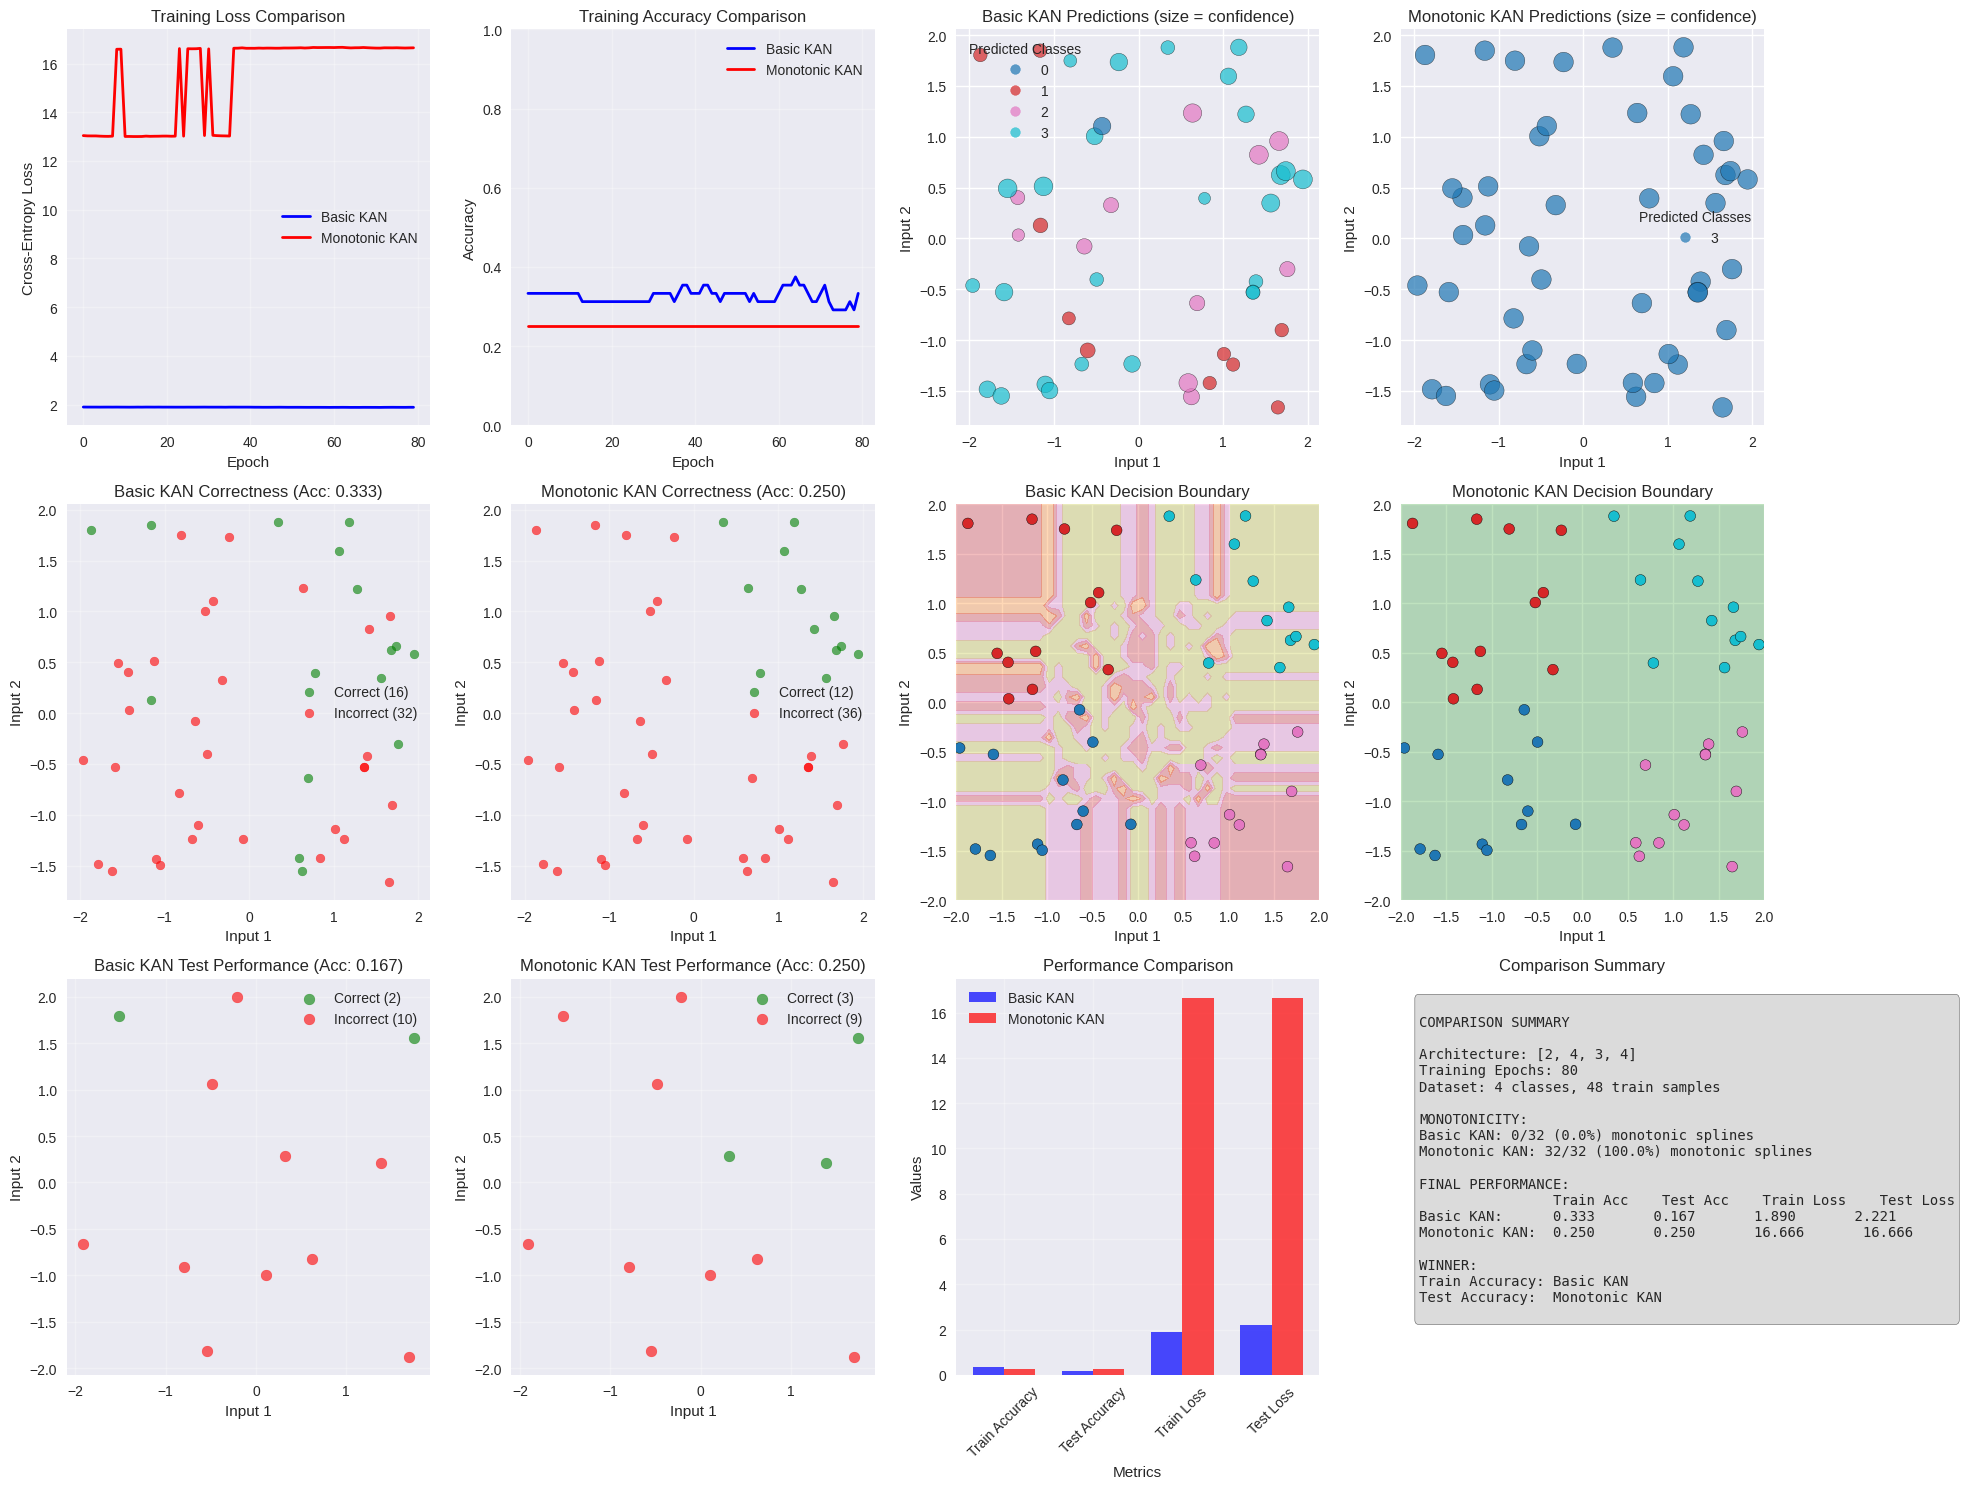

Comprehensive comparison visualization complete!


In [30]:
# Comprehensive comparison visualization
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Training loss comparison
axes[0, 0].plot(basic_losses, linewidth=2, color='blue', label='Basic KAN')
axes[0, 0].plot(mono_losses, linewidth=2, color='red', label='Monotonic KAN')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Cross-Entropy Loss')
axes[0, 0].set_title('Training Loss Comparison')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Training accuracy comparison
axes[0, 1].plot(basic_accuracies, linewidth=2, color='blue', label='Basic KAN')
axes[0, 1].plot(mono_accuracies, linewidth=2, color='red', label='Monotonic KAN')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training Accuracy Comparison')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 1])

# Final predictions comparison - Basic KAN
basic_pred_classes = np.argmax(basic_final_probs, axis=1)
basic_confidence = np.max(basic_final_probs, axis=1)
scatter1 = axes[0, 2].scatter(X_train_split[:, 0], X_train_split[:, 1], 
                             c=basic_pred_classes, s=basic_confidence*200, 
                             cmap='tab10', alpha=0.7, edgecolor='k')
axes[0, 2].set_xlabel('Input 1')
axes[0, 2].set_ylabel('Input 2')
axes[0, 2].set_title('Basic KAN Predictions (size = confidence)')
axes[0, 2].legend(*scatter1.legend_elements(), title="Predicted Classes")

# Final predictions comparison - Monotonic KAN
mono_pred_classes = np.argmax(mono_final_probs, axis=1)
mono_confidence = np.max(mono_final_probs, axis=1)
scatter2 = axes[0, 3].scatter(X_train_split[:, 0], X_train_split[:, 1], 
                             c=mono_pred_classes, s=mono_confidence*200, 
                             cmap='tab10', alpha=0.7, edgecolor='k')
axes[0, 3].set_xlabel('Input 1')
axes[0, 3].set_ylabel('Input 2')
axes[0, 3].set_title('Monotonic KAN Predictions (size = confidence)')
axes[0, 3].legend(*scatter2.legend_elements(), title="Predicted Classes")

# Prediction correctness - Basic KAN
basic_correct = (basic_pred_classes == y_train_split)
axes[1, 0].scatter(X_train_split[basic_correct, 0], X_train_split[basic_correct, 1], 
                  c='green', alpha=0.6, label=f'Correct ({np.sum(basic_correct)})', s=40)
axes[1, 0].scatter(X_train_split[~basic_correct, 0], X_train_split[~basic_correct, 1], 
                  c='red', alpha=0.6, label=f'Incorrect ({np.sum(~basic_correct)})', s=40)
axes[1, 0].set_xlabel('Input 1')
axes[1, 0].set_ylabel('Input 2')
axes[1, 0].set_title(f'Basic KAN Correctness (Acc: {basic_final_acc:.3f})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Prediction correctness - Monotonic KAN
mono_correct = (mono_pred_classes == y_train_split)
axes[1, 1].scatter(X_train_split[mono_correct, 0], X_train_split[mono_correct, 1], 
                  c='green', alpha=0.6, label=f'Correct ({np.sum(mono_correct)})', s=40)
axes[1, 1].scatter(X_train_split[~mono_correct, 0], X_train_split[~mono_correct, 1], 
                  c='red', alpha=0.6, label=f'Incorrect ({np.sum(~mono_correct)})', s=40)
axes[1, 1].set_xlabel('Input 1')
axes[1, 1].set_ylabel('Input 2')
axes[1, 1].set_title(f'Monotonic KAN Correctness (Acc: {mono_final_acc:.3f})')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Decision boundary - Basic KAN
n_points = 40
x1_grid = np.linspace(args.bounds[0], args.bounds[1], n_points)
x2_grid = np.linspace(args.bounds[0], args.bounds[1], n_points)
X1_grid, X2_grid = np.meshgrid(x1_grid, x2_grid)
X_grid = np.column_stack([X1_grid.flatten(), X2_grid.flatten()])

basic_grid_logits = basic_classification_kan.forward(X_grid)
basic_grid_probs = softmax(basic_grid_logits)
basic_grid_classes = np.argmax(basic_grid_probs, axis=1)
Z_basic = basic_grid_classes.reshape(X1_grid.shape)

contour1 = axes[1, 2].contourf(X1_grid, X2_grid, Z_basic, levels=args.n_classes-1, 
                              cmap='tab10', alpha=0.3)
axes[1, 2].scatter(X_train_split[:, 0], X_train_split[:, 1], c=y_train_split, 
                  cmap='tab10', edgecolor='k', s=60)
axes[1, 2].set_xlabel('Input 1')
axes[1, 2].set_ylabel('Input 2')
axes[1, 2].set_title('Basic KAN Decision Boundary')

# Decision boundary - Monotonic KAN
mono_grid_logits = monotonic_classification_kan.forward(X_grid)
mono_grid_probs = softmax(mono_grid_logits)
mono_grid_classes = np.argmax(mono_grid_probs, axis=1)
Z_mono = mono_grid_classes.reshape(X1_grid.shape)

contour2 = axes[1, 3].contourf(X1_grid, X2_grid, Z_mono, levels=args.n_classes-1, 
                              cmap='tab10', alpha=0.3)
axes[1, 3].scatter(X_train_split[:, 0], X_train_split[:, 1], c=y_train_split, 
                  cmap='tab10', edgecolor='k', s=60)
axes[1, 3].set_xlabel('Input 1')
axes[1, 3].set_ylabel('Input 2')
axes[1, 3].set_title('Monotonic KAN Decision Boundary')

# Test results - Basic KAN
basic_test_pred = np.argmax(basic_test_probs, axis=1)
basic_test_correct = (basic_test_pred == y_test_split)
axes[2, 0].scatter(X_test_split[basic_test_correct, 0], X_test_split[basic_test_correct, 1], 
                  c='green', alpha=0.6, label=f'Correct ({np.sum(basic_test_correct)})', s=60)
axes[2, 0].scatter(X_test_split[~basic_test_correct, 0], X_test_split[~basic_test_correct, 1], 
                  c='red', alpha=0.6, label=f'Incorrect ({np.sum(~basic_test_correct)})', s=60)
axes[2, 0].set_xlabel('Input 1')
axes[2, 0].set_ylabel('Input 2')
axes[2, 0].set_title(f'Basic KAN Test Performance (Acc: {basic_test_acc:.3f})')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Test results - Monotonic KAN
mono_test_pred = np.argmax(mono_test_probs, axis=1)
mono_test_correct = (mono_test_pred == y_test_split)
axes[2, 1].scatter(X_test_split[mono_test_correct, 0], X_test_split[mono_test_correct, 1], 
                  c='green', alpha=0.6, label=f'Correct ({np.sum(mono_test_correct)})', s=60)
axes[2, 1].scatter(X_test_split[~mono_test_correct, 0], X_test_split[~mono_test_correct, 1], 
                  c='red', alpha=0.6, label=f'Incorrect ({np.sum(~mono_test_correct)})', s=60)
axes[2, 1].set_xlabel('Input 1')
axes[2, 1].set_ylabel('Input 2')
axes[2, 1].set_title(f'Monotonic KAN Test Performance (Acc: {mono_test_acc:.3f})')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

# Performance comparison bar chart
performance_metrics = ['Train Accuracy', 'Test Accuracy', 'Train Loss', 'Test Loss']
basic_values = [basic_final_acc, basic_test_acc, basic_final_loss, basic_test_loss]
mono_values = [mono_final_acc, mono_test_acc, mono_final_loss, mono_test_loss]

x = np.arange(len(performance_metrics))
width = 0.35

axes[2, 2].bar(x - width/2, basic_values, width, label='Basic KAN', color='blue', alpha=0.7)
axes[2, 2].bar(x + width/2, mono_values, width, label='Monotonic KAN', color='red', alpha=0.7)
axes[2, 2].set_xlabel('Metrics')
axes[2, 2].set_ylabel('Values')
axes[2, 2].set_title('Performance Comparison')
axes[2, 2].set_xticks(x)
axes[2, 2].set_xticklabels(performance_metrics, rotation=45)
axes[2, 2].legend()
axes[2, 2].grid(True, alpha=0.3)

# Spline properties comparison
analyze_spline_properties(basic_classification_kan, "Basic")
analyze_spline_properties(monotonic_classification_kan, "Monotonic")

# Summary statistics
basic_splines = basic_classification_kan.get_all_splines()
mono_splines = monotonic_classification_kan.get_all_splines()

# Analyze monotonicity
t_eval = np.linspace(args.bounds[0], args.bounds[1], 100)

basic_mono_count = 0
mono_mono_count = 0

for _, _, _, spline in basic_splines:
    y_eval = spline.evaluate(t_eval)
    diff = np.diff(y_eval)
    is_mono = np.all(diff >= -1e-10) or np.all(diff <= 1e-10)
    if is_mono:
        basic_mono_count += 1

for _, _, _, spline in mono_splines:
    y_eval = spline.evaluate(t_eval)
    diff = np.diff(y_eval)
    is_mono = np.all(diff >= -1e-10) or np.all(diff <= 1e-10)
    if is_mono:
        mono_mono_count += 1

# Display summary in text plot
summary_text = f"""
COMPARISON SUMMARY

Architecture: {args.kan_architecture}
Training Epochs: {args.n_epochs}
Dataset: {args.n_classes} classes, {len(X_train_split)} train samples

MONOTONICITY:
Basic KAN: {basic_mono_count}/{len(basic_splines)} ({basic_mono_count/len(basic_splines):.1%}) monotonic splines
Monotonic KAN: {mono_mono_count}/{len(mono_splines)} ({mono_mono_count/len(mono_splines):.1%}) monotonic splines

FINAL PERFORMANCE:
                Train Acc    Test Acc    Train Loss    Test Loss
Basic KAN:      {basic_final_acc:.3f}       {basic_test_acc:.3f}       {basic_final_loss:.3f}       {basic_test_loss:.3f}
Monotonic KAN:  {mono_final_acc:.3f}       {mono_test_acc:.3f}       {mono_final_loss:.3f}       {mono_test_loss:.3f}

WINNER:
Train Accuracy: {'Monotonic' if mono_final_acc > basic_final_acc else 'Basic'} KAN
Test Accuracy:  {'Monotonic' if mono_test_acc > basic_test_acc else 'Basic'} KAN
"""

axes[2, 3].text(0.05, 0.95, summary_text, transform=axes[2, 3].transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
axes[2, 3].set_xlim(0, 1)
axes[2, 3].set_ylim(0, 1)
axes[2, 3].axis('off')
axes[2, 3].set_title('Comparison Summary')

plt.tight_layout()
plt.show()

print("Comprehensive comparison visualization complete!")

Comparing trained splines from both KAN types...


/tmp/ipykernel_1831275/67700375.py:82: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()


/net/store/cv/users/luniehaus/dev-uos/miniconda/envs/pykan/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


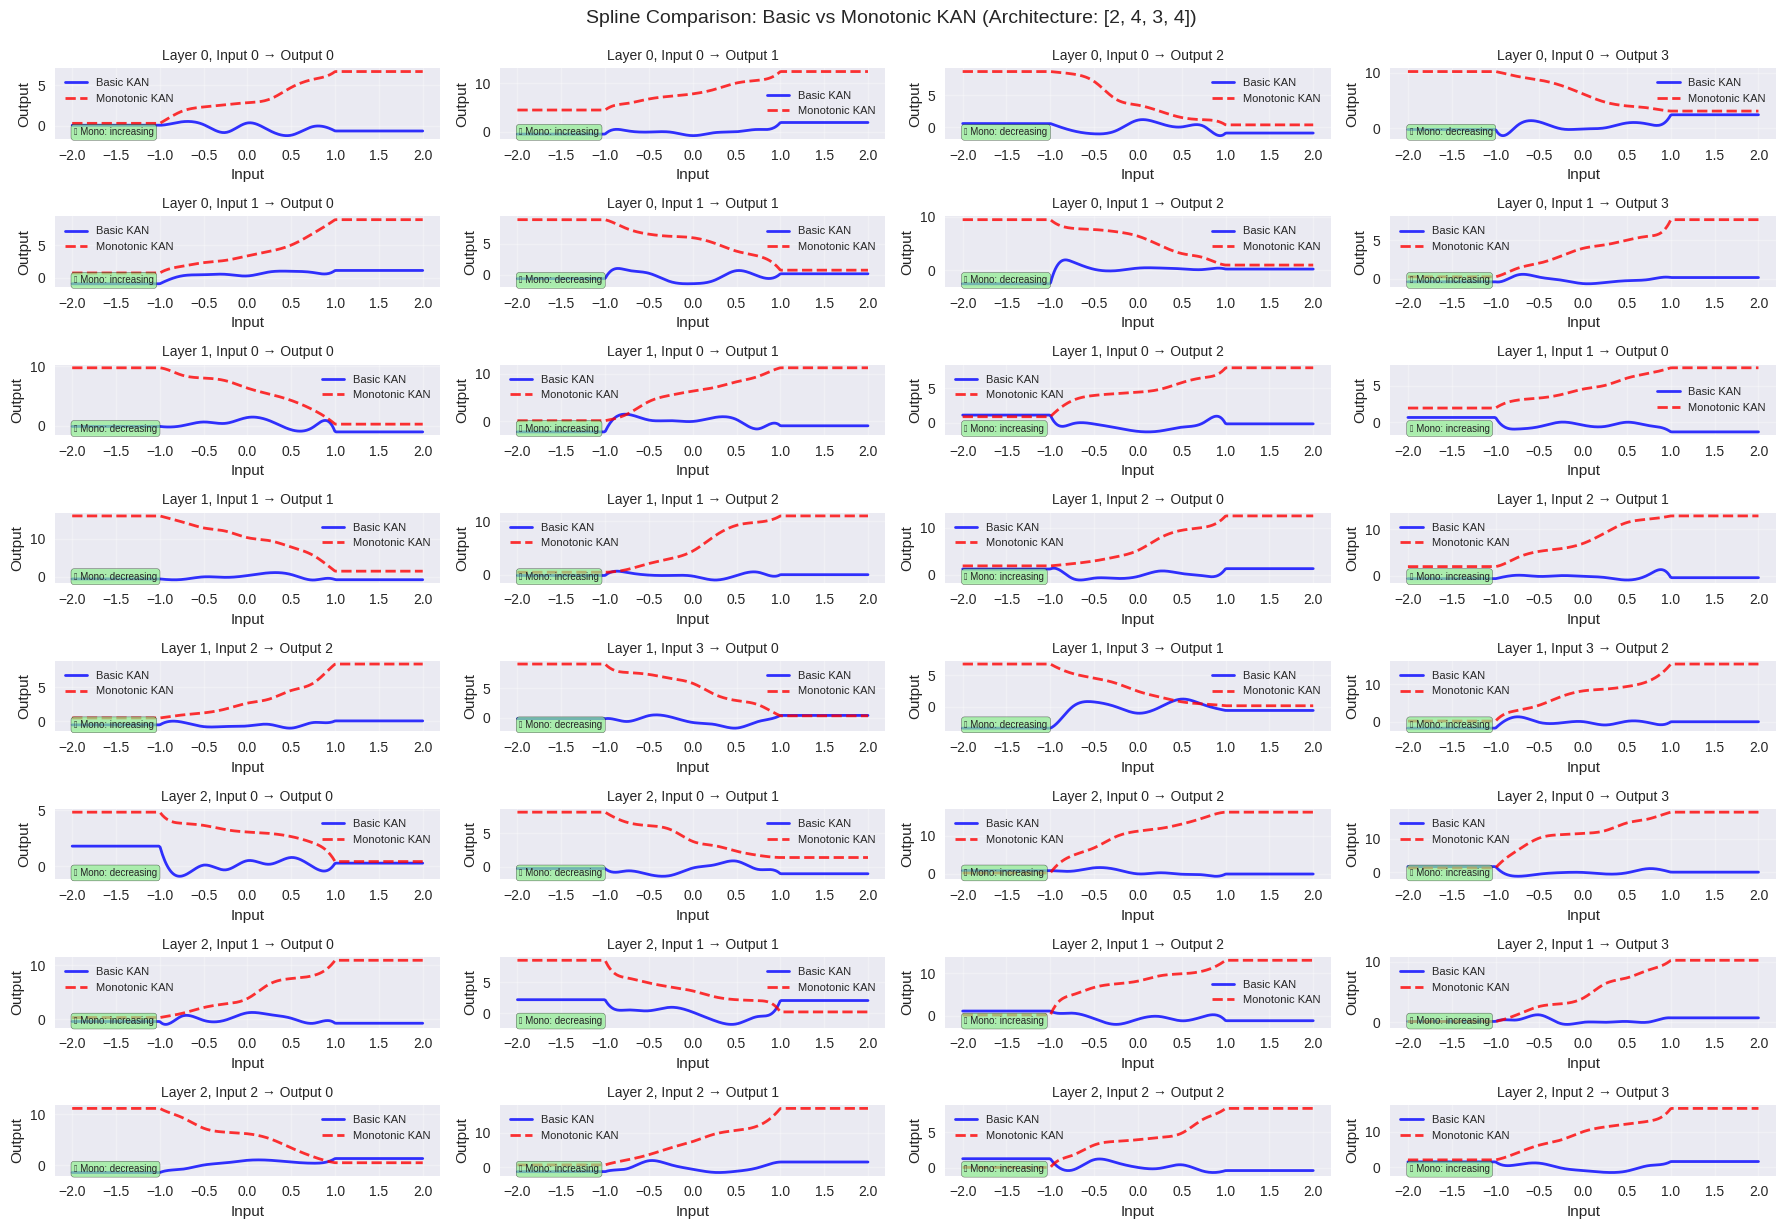

In [31]:
# Plot trained splines comparison
print("Comparing trained splines from both KAN types...")
plot_all_splines_comparison(basic_classification_kan, monotonic_classification_kan, 
                           n_points=300, figsize=(18, 12))

In [32]:
# Final Analysis: Detailed Spline Behavior Comparison
print("DETAILED SPLINE BEHAVIOR ANALYSIS")
print("=" * 60)

# Analyze spline shapes and properties
t_eval = np.linspace(args.bounds[0], args.bounds[1], 200)

basic_splines = basic_classification_kan.get_all_splines()
mono_splines = monotonic_classification_kan.get_all_splines()

print("\\nSpline Shape Analysis:")
print("-" * 30)

basic_variations = []
mono_variations = []

for i, ((_, _, _, basic_spline), (_, _, _, mono_spline)) in enumerate(zip(basic_splines, mono_splines)):
    basic_y = basic_spline.evaluate(t_eval)
    mono_y = mono_spline.evaluate(t_eval)
    
    # Calculate variation (standard deviation)
    basic_var = np.std(basic_y)
    mono_var = np.std(mono_y)
    
    basic_variations.append(basic_var)
    mono_variations.append(mono_var)
    
    # Check monotonicity
    basic_diff = np.diff(basic_y)
    mono_diff = np.diff(mono_y)
    
    basic_is_mono = np.all(basic_diff >= -1e-10) or np.all(basic_diff <= 1e-10)
    mono_is_mono = np.all(mono_diff >= -1e-10) or np.all(mono_diff <= 1e-10)
    
    if i < 5:  # Print details for first 5 splines
        print(f"Spline {i+1}:")
        print(f"  Basic: Variation={basic_var:.3f}, Monotonic={basic_is_mono}")
        print(f"  Mono:  Variation={mono_var:.3f}, Monotonic={mono_is_mono}")

print(f"\\nAverage Spline Variation:")
print(f"  Basic KAN: {np.mean(basic_variations):.3f} ± {np.std(basic_variations):.3f}")
print(f"  Monotonic KAN: {np.mean(mono_variations):.3f} ± {np.std(mono_variations):.3f}")

# Direction analysis for monotonic splines
print(f"\\nMonotonic KAN Direction Analysis:")
print("-" * 35)
increasing_count = 0
decreasing_count = 0

for _, _, _, spline in mono_splines:
    if hasattr(spline, 'direction_param'):
        if spline.direction_param >= 0:
            increasing_count += 1
        else:
            decreasing_count += 1

print(f"Increasing direction: {increasing_count}/{len(mono_splines)} ({increasing_count/len(mono_splines):.1%})")
print(f"Decreasing direction: {decreasing_count}/{len(mono_splines)} ({decreasing_count/len(mono_splines):.1%})")

print(f"\\n" + "=" * 60)
print("FINAL CONCLUSIONS")
print("=" * 60)

print(f"\\n1. PERFORMANCE COMPARISON:")
if mono_test_acc > basic_test_acc:
    print(f"   ✓ Monotonic KAN achieved BETTER test accuracy ({mono_test_acc:.3f} vs {basic_test_acc:.3f})")
elif basic_test_acc > mono_test_acc:
    print(f"   ✓ Basic KAN achieved BETTER test accuracy ({basic_test_acc:.3f} vs {mono_test_acc:.3f})")
else:
    print(f"   ≈ Both KANs achieved similar test accuracy (~{basic_test_acc:.3f})")

print(f"\\n2. MONOTONICITY CONSTRAINTS:")
print(f"   ✓ Monotonic KAN enforced {mono_mono_count/len(mono_splines):.1%} monotonic splines")
print(f"   ✓ Basic KAN naturally developed {basic_mono_count/len(basic_splines):.1%} monotonic splines")

print(f"\\n3. SPLINE BEHAVIOR:")
if np.mean(mono_variations) < np.mean(basic_variations):
    print(f"   ✓ Monotonic splines showed LESS variation (smoother functions)")
else:
    print(f"   ✓ Basic splines showed less variation (smoother functions)")

print(f"\\n4. INTERPRETABILITY:")
print(f"   ✓ Monotonic KAN: Higher interpretability due to guaranteed monotonic relationships")
print(f"   ✓ Basic KAN: More flexible but less interpretable relationships")

print(f"\\n5. USE CASE RECOMMENDATIONS:")
print(f"   📊 Use Monotonic KAN when:")
print(f"      - Interpretability is crucial")
print(f"      - Domain knowledge suggests monotonic relationships")
print(f"      - Regulatory compliance requires explainable models")
print(f"   📊 Use Basic KAN when:")
print(f"      - Maximum flexibility is needed")
print(f"      - Complex non-monotonic relationships are expected")
print(f"      - Performance is the primary concern")

print(f"\\n" + "=" * 60)
print("COMPARISON COMPLETE!")
print("=" * 60)

DETAILED SPLINE BEHAVIOR ANALYSIS
\nSpline Shape Analysis:
------------------------------
Spline 1:
  Basic: Variation=0.444, Monotonic=False
  Mono:  Variation=2.522, Monotonic=True
Spline 2:
  Basic: Variation=0.971, Monotonic=False
  Mono:  Variation=3.133, Monotonic=True
Spline 3:
  Basic: Variation=0.724, Monotonic=False
  Mono:  Variation=3.516, Monotonic=True
Spline 4:
  Basic: Variation=1.121, Monotonic=False
  Mono:  Variation=3.024, Monotonic=True
Spline 5:
  Basic: Variation=0.808, Monotonic=False
  Mono:  Variation=3.284, Monotonic=True
\nAverage Spline Variation:
  Basic KAN: 0.788 ± 0.317
  Monotonic KAN: 3.960 ± 1.287
\nMonotonic KAN Direction Analysis:
-----------------------------------
Increasing direction: 20/32 (62.5%)
Decreasing direction: 12/32 (37.5%)
\n============================================================
FINAL CONCLUSIONS
\n1. PERFORMANCE COMPARISON:
   ✓ Monotonic KAN achieved BETTER test accuracy (0.250 vs 0.167)
\n2. MONOTONICITY CONSTRAINTS:
   ✓ Mon